In [1]:
#inport require libraries
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

In [2]:
class Layer:
    """
    Layer class is the interface which will be inherited by the each and every class of our package
    Inputs will store the initial value or the value obtain in the forward pass
    Outputs will store the obtain from the backward pass
    
    """
    def __init__(self):
        self.inputs = None
        self.outputs = None

    def forward(self):
        pass

    def backward(self):
        pass

In [3]:
class Linear(Layer):
    """
    Linear will inherit layer interface
    here weights and bias will be initialize according to the number of neurons
    For will give output in forward y=wx+b
    In backward local gradient and upstream gradient will also be calculated 
    derivative of Z with respect to X and B will be calculated]
    derivative of cost with respect to weight  and Bias will be calculated
    weight and bias will be adjusted according to dc_dw,dc_db
    """

    def __init__(self,num_input_neurons,num_output_neurons):
        super().__init__()
        np.random.seed(250)
        weight_shape = (num_output_neurons, num_input_neurons)
        self.weights = np.random.randn(*weight_shape)
        self.bias = np.random.rand(num_output_neurons)

    def forward(self, X):
        # print(self.weights.shape)
        # print(X.shape)
        # print(self.bias.shape)
        self.X = X
        self.outputs = ((np.dot(self.weights, self.X.T)).T + self.bias) # y= wx+b
        # print(self.outputs.shape)
        return self.outputs
    
    def backward(self, upstream_grad_in, lr):
        # print("b",self.weights.shape)
        # print("b",upstream_grad_in.shape)
        # print("b",self.bias.shape)
        dz_dx = self.X # wrt to dz_dx
        dz_db = 1 # it will be one
        dc_dw = np.dot(upstream_grad_in.T, dz_dx) # dot product of upstream grad with dz_dx
        dc_db = np.sum(upstream_grad_in * dz_db, axis=0) # dot product of upstream grad with dz_db
        upstream_grad_out = np.dot(upstream_grad_in, self.weights)
        self.weightd_loss_arr = np.dot(upstream_grad_in.T, self.X)
        self.weights = self.weights - (lr * self.weightd_loss_arr) # update weight
        self.bias = self.bias - (lr * upstream_grad_in) #update bias
        return upstream_grad_out

In [4]:
class Sigmoid(Layer):
    """
    Sigmoid will inherit layer interface
    outputs will be given as per 1/1+e^-x for forward
    for backward it will take local gradient as output val * 1 - output val

    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = (1 /( 1 + np.exp(-inputs))) # 1/1+e^-x 
        return self.outputs

    def backward(self, upstream_grad_in, lr):
        loc_grad = self.outputs * (1 - self.outputs) # calculating the local grad
        dl_dz = upstream_grad_in * loc_grad # for getting upstream grad multiply prev val with loc_grad

        return dl_dz

In [5]:
class TanH(Layer):
    """
    HyperTangent will inherit layer interface
    outputs will be given as per np.tanh for forward
    for backward it will take local gradient as subtracting square of inputs from 1

    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.tanh(inputs) # to calculate hypertangent for forward pass
        return self.outputs

    def backward(self, upstream_grad_in, lr):
        loc_grad = 1-np.power(np.tanh(self.inputs),2) # subtracting square of inputs from 1
        dl_dz = loc_grad * upstream_grad_in # # for getting upstream grad multiply prev val with loc_grad
        return dl_dz

In [6]:
class Softmax(Layer):
    """
    Softmax will inherit layer interface
    outputs will be given as per softmax for forward
    for backward i have taken reference of your repo
    https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.exp(inputs) / np.sum(np.exp(inputs), axis=1) # as per ypur repo
        return self.outputs

    def backward(self, upstream_grad_in, lr):
        
        # gradient = 1 / (1 + np.exp(-self.inputs))
        # gradient * (1- gradient) * upstream_grad_in
        return upstream_grad_in

In [7]:
class CrossEntropyLoss(Layer):
    """
    CrossEntropyLoss will inherit layer interface
    outputs will be given as per formula 
    Here np.clip is used to remove NaN error

    https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
    """

    def __init__(self):
        super().__init__()

    def forward(self, y, y_pred):
        #actual,pred
        self.inputs = y_pred # predicted value
        self.inputs = np.clip(self.inputs, 1e-15, 1 - 1e-15) # to remove NaN error
        self.actual_y = y # actual y value
        self.outputs = -np.sum(self.actual_y * np.log(self.inputs)) # as per the formula
        # y = np.clip(y,1e-15,1-1e-15)
        return self.outputs

    def backward(self, upstream_grad_in, lr):
        local_gradient = (self.inputs - self.actual_y) # loc grad will be input - output
        dl_dy = upstream_grad_in * local_gradient # for getting upstream grad multiply prev val with loc_grad
        return dl_dy

In [8]:
class Sequential(Layer):
  """
    Sequential will inherit layer interface as executioner class
    Add will be used to add a layer
    Layers, loss_arr, err_val will be initialed to empty
    use_loss will be used to define various loss function here cross entropy
    Will iterate for each samples and each epoch
    train and validation set will be used 
    https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
  """

  def __init__(self):
      super().__init__()
      self.layers = []
      self.loss = None
      self.loss_arr = []
      self.err_val = []

  def add(self,layer):
      self.layers.append(layer) # will add layer

  def use_loss(self,e):
    self.loss = e # Loss class will be added

  def fit(self, X, y, X_val=None, y_val=None, steps=10, lr=0.01):
    self.lr = lr # learning rate will be define
    c = 0 # to keep count
    best_val_loss = float('inf') # initialize beest weight
    n_samples = X.shape[0] # get no. of samples
    n_val_samples = X_val.shape[0] if X_val is not None else 0 # check for val samples if given
    for i in range(steps): #iterate each epoch
        tot_e = 0 # total train loss
  
        for j in range(n_samples): # for each samples
            y_pred = X[j] # pick each y_pred
            if (y_pred.ndim == 1):
              y_pred = y_pred[None, :] # solving it to resolve shape error

            for layer in self.layers: # itereate each layers forward
                y_pred = layer.forward(y_pred)

            # tot_e += self.loss.forward(y[j],y_pred)
            tot_e += self.loss.forward(y[j],y_pred) # calculate loss from given

            output_loss = np.array(self.loss.backward(1,lr)) # send 1 as first local grad
            
            for layer in reversed(self.layers): # itereate each layers reversely
                output_loss = layer.backward(output_loss,lr)
        tot_e = tot_e/n_samples # divide by n to get avg
        self.loss_arr.append(round(tot_e, 6)) # store over each epoch
        if X_val is not None and y_val is not None: # this is for Validation set 
            tot_val_e = 0
            for j in range(n_val_samples):
                y_val_pred = X_val[j]
                if (y_val_pred.ndim == 1):
                    y_val_pred = y_val_pred[None, :]

                for layer in self.layers:
                    y_val_pred = layer.forward(y_val_pred)

                tot_val_e += np.sum(np.mean(self.loss.forward(y_val[j], y_val_pred)))

            tot_val_e = tot_val_e / n_val_samples # divide by n to get avg
            self.err_val.append(tot_val_e)

            if tot_val_e < best_val_loss: #get best val loss and update to 0
                best_val_loss = tot_val_e
                c = 0
            else:
                c += 1 #increment by 1

        if c >= 5: # stoping function
            print(f"Stopping early after epoch {i+1} due to no improvement in validation loss.")
            break
        # np.savetxt("XOR.w", np.concatenate((self.weights.ravel(), b1.ravel(), W2.ravel(), b2.ravel())), delimiter=",")

        print(f"Epoch {i+1} :: training loss: {tot_e:.6f} :: validation loss: {tot_val_e:.6f}" if X_val is not None and y_val is not None else f"Epoch {i+1} :: training loss: {tot_e:.6f}")

  def predict(self, X): # predict from given input with weights and bias
    n_samples = X.shape[0]
    y_output = []
    y_pred = []
    for i in range(n_samples):
      out = X[i]

      for j in self.layers:
          out = j.forward(out)
      y_output.append(out)


    for out in y_output:# using some threshold value
      out[out>0.5] = 1
      out[out<0.5] = 0
    for out in y_output:
      y_pred.append(np.argmax(out,axis=0))
    print(y_pred)
    return np.array(y_output)


  def plot(self): # plot functiuon
    plt.figure(figsize=(20,8))
    plt.plot(self.loss_arr, label = 'Training Loss') # train loss
    plt.plot(self.err_val, label = 'Validation Loss') # val_ loss

    plt.title(f"Loss VS Epoch :: Learning Rate : {self.lr}", fontsize=15)
    plt.xlabel("Epoch",fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.legend()

    plt.show()

In [9]:
samples = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
targets = np.array([[0], [1], [1], [0]])

In [10]:
network1 = Sequential()
network1.add(Linear(2,1))
network1.add(Sigmoid())
network1.use_loss(CrossEntropyLoss())


In [11]:
network1.fit(samples,targets,None,None,10,0.001)

Epoch 1 :: training loss: 0.466618
Epoch 2 :: training loss: 0.466554
Epoch 3 :: training loss: 0.466490
Epoch 4 :: training loss: 0.466426
Epoch 5 :: training loss: 0.466363
Epoch 6 :: training loss: 0.466299
Epoch 7 :: training loss: 0.466235
Epoch 8 :: training loss: 0.466172
Epoch 9 :: training loss: 0.466108
Epoch 10 :: training loss: 0.466045


In [12]:
with open('XOR_solved_sigmoid.w', 'wb') as p_file:
    pickle.dump(network1, p_file, pickle.HIGHEST_PROTOCOL)
net = None
with open('XOR_solved_sigmoid.w', 'rb') as p_file:
    net = pickle.load(p_file)
net.predict(samples)


[array([0]), array([0]), array([0]), array([0])]


array([[[1.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [13]:
network1.predict(samples)

[array([0]), array([0]), array([0]), array([0])]


array([[[1.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [14]:
network2 = Sequential()
network2.add(Linear(2,1))
network2.add(TanH())
network2.use_loss(CrossEntropyLoss())
network2.fit(samples,targets,None,None,10,0.001)
with open('XOR_solved_tanh.w', 'wb') as p_file:
    pickle.dump(network2, p_file, pickle.HIGHEST_PROTOCOL)
net = None
with open('XOR_solved_tanh.w', 'rb') as p_file:
    net = pickle.load(p_file)
net.predict(samples)

network2.predict(samples)

Epoch 1 :: training loss: 17.269388
Epoch 2 :: training loss: 17.269388
Epoch 3 :: training loss: 17.269388
Epoch 4 :: training loss: 17.269388
Epoch 5 :: training loss: 17.269388
Epoch 6 :: training loss: 17.269388
Epoch 7 :: training loss: 17.269388
Epoch 8 :: training loss: 17.269388
Epoch 9 :: training loss: 17.269388
Epoch 10 :: training loss: 17.269388
[array([0]), array([0]), array([0]), array([0])]
[array([0]), array([0]), array([0]), array([0])]


array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

**According to observation seeing the loss, loss in sigmoid is less and also decreasing than Tanh so sigmoid is easy to train** 

In [15]:
network3 = Sequential()
network3.add(Linear(2,2))
network3.add(Sigmoid())
network3.add(Linear(2,1))
network3.add(TanH())
network2.use_loss(CrossEntropyLoss())
network2.fit(samples,targets,None,None,10,0.001)

with open('XOR_solved.w', 'wb') as p_file:
    pickle.dump(network3, p_file, pickle.HIGHEST_PROTOCOL)
net = None
with open('XOR_solved.w', 'rb') as p_file:
    net = pickle.load(p_file)
net.predict(samples)
network3.predict(samples)

Epoch 1 :: training loss: 17.269388
Epoch 2 :: training loss: 17.269388
Epoch 3 :: training loss: 17.269388
Epoch 4 :: training loss: 17.269388
Epoch 5 :: training loss: 17.269388
Epoch 6 :: training loss: 17.269388
Epoch 7 :: training loss: 17.269388
Epoch 8 :: training loss: 17.269388
Epoch 9 :: training loss: 17.269388
Epoch 10 :: training loss: 17.269388
[0, 0, 0, 0]
[0, 0, 0, 0]


array([[0.],
       [0.],
       [0.],
       [0.]])

In [16]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],1,28*28)
X_train = X_train.astype(np.float64)
X_train /= 255
X_train = X_train.squeeze()
X_test = X_test.reshape(X_test.shape[0],1,28*28)
X_test = X_test.astype(np.float64).squeeze()
X_test /= 255

11490434/11490434 [==============================] - 0s 0us/step


In [17]:
def get_one_hot(targets, nb_classes): # One hot encoder for Y input
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)] #Return a 2-D array with ones on the diagonal and zeros elsewhere.
    return res.reshape(list(targets.shape)+[nb_classes])

In [18]:
y_train =  get_one_hot(y_train.astype(int), 10)
y_test = get_one_hot(y_test.astype(int), 10)

In [19]:
# this is for splitting training and validation set
train_ratio = 0.9
train_size = int(train_ratio * X_train.shape[0])
X_Val = X_train[train_size:]
Y_Val = y_train[train_size:]
X_train = X_train[:train_size]
y_train = y_train[:train_size]


Model1

In [20]:
model_1 = Sequential()
model_1.add(Linear(28*28,64))
model_1.add(Sigmoid())
model_1.add(Linear(64,10))
model_1.add(Sigmoid())
model_1.use_loss(CrossEntropyLoss())
model_1.fit(X_train,y_train,X_Val,Y_Val,10,0.001)

Epoch 1 :: training loss: 5.258076 :: validation loss: 6.210788
Epoch 2 :: training loss: 6.179966 :: validation loss: 6.223455
Epoch 3 :: training loss: 6.048340 :: validation loss: 5.955328
Epoch 4 :: training loss: 5.781719 :: validation loss: 5.674046
Epoch 5 :: training loss: 5.545523 :: validation loss: 5.447875
Epoch 6 :: training loss: 5.339266 :: validation loss: 5.250951
Epoch 7 :: training loss: 5.156286 :: validation loss: 5.087723
Epoch 8 :: training loss: 5.009759 :: validation loss: 4.962671
Epoch 9 :: training loss: 4.892519 :: validation loss: 4.857498
Epoch 10 :: training loss: 4.787719 :: validation loss: 4.757338


In [21]:
predicted = model_1.predict(X_test)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0,

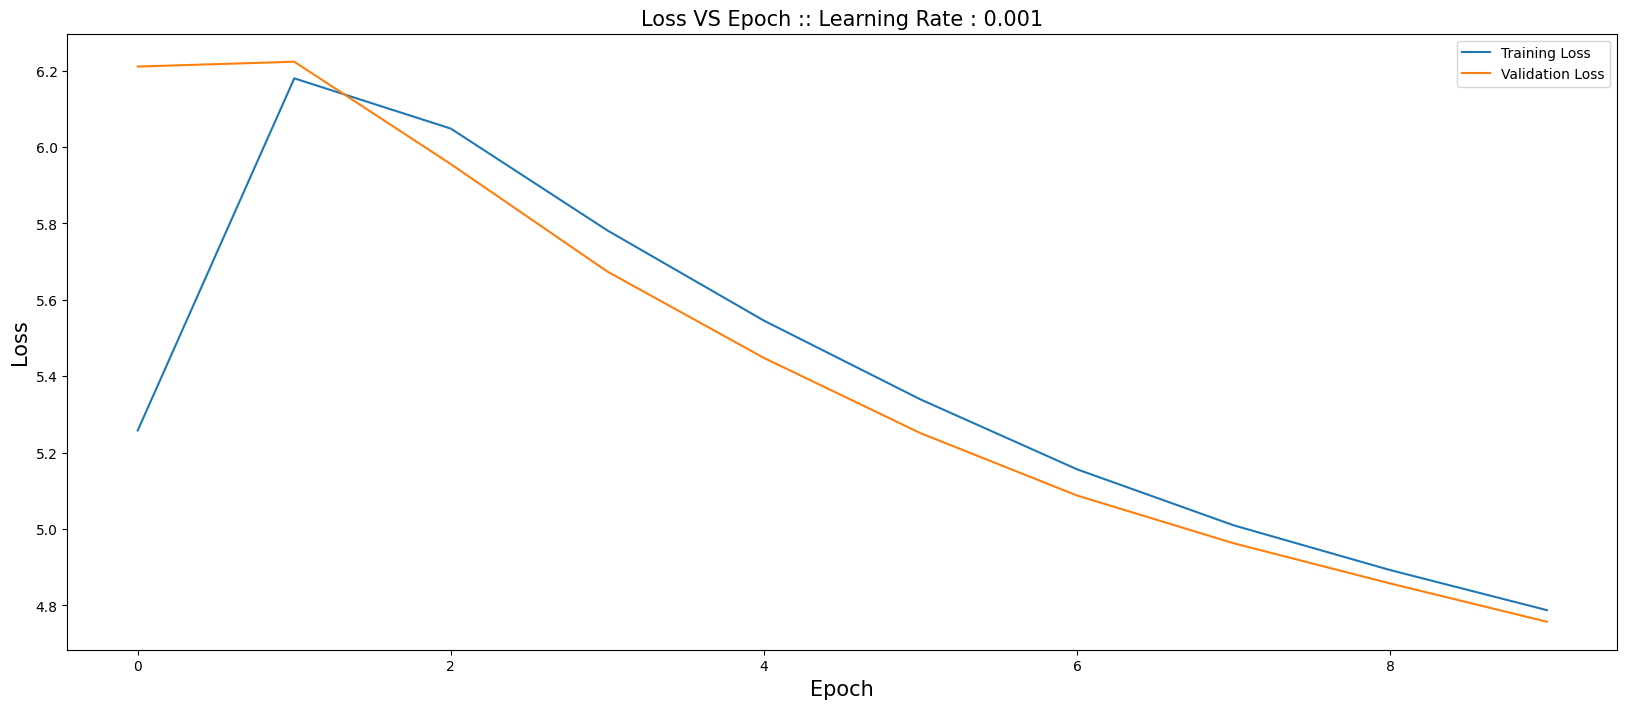

In [22]:
model_1.plot()

Model 2

In [23]:
model_2 = Sequential()
model_2.add(Linear(28*28,64))
model_2.add(TanH())
model_2.add(Linear(64,10))
model_2.add(Sigmoid())
model_2.use_loss(CrossEntropyLoss())
model_2.fit(X_train,y_train,X_Val,Y_Val,10,0.001)

Epoch 1 :: training loss: 7.384481 :: validation loss: 9.989732
Epoch 2 :: training loss: 10.498193 :: validation loss: 10.872404
Epoch 3 :: training loss: 10.964414 :: validation loss: 11.083820
Epoch 4 :: training loss: 11.010705 :: validation loss: 11.017752
Epoch 5 :: training loss: 10.829676 :: validation loss: 10.718054
Stopping early after epoch 6 due to no improvement in validation loss.


In [24]:
predicted = model_2.predict(X_test)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0,

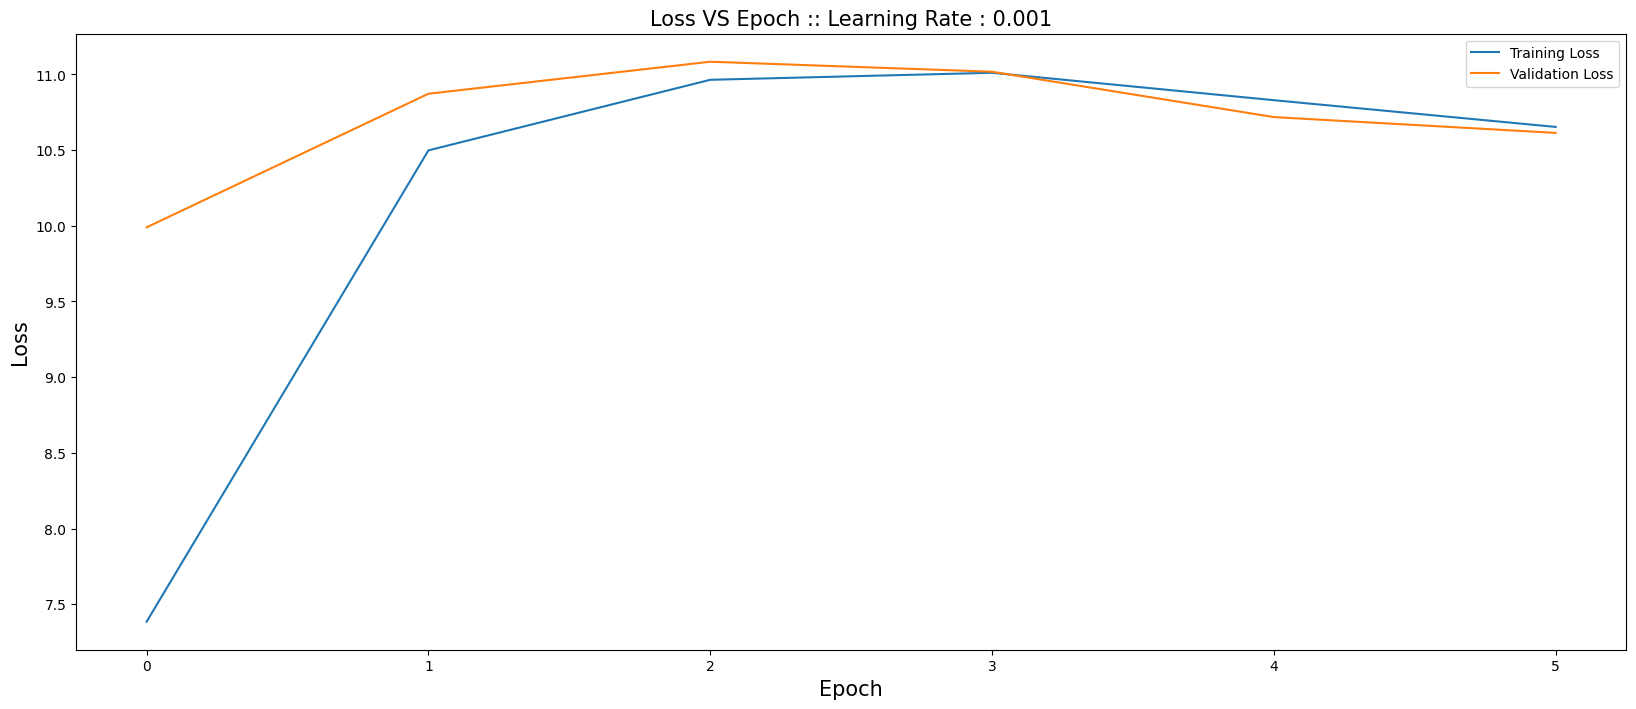

In [25]:
model_2.plot()

Model 3

In [26]:
model_3 = Sequential()
model_3.add(Linear(28*28,64))
model_3.add(TanH())
model_3.add(Linear(64,10))
model_3.add(TanH())
model_3.use_loss(CrossEntropyLoss())
model_3.fit(X_train,y_train,X_Val,Y_Val,10,0.001)

Epoch 1 :: training loss: 20.266883 :: validation loss: 20.559043
Epoch 2 :: training loss: 18.827565 :: validation loss: 16.902475
Epoch 3 :: training loss: 15.068900 :: validation loss: 12.781789
Epoch 4 :: training loss: 12.221018 :: validation loss: 10.897481
Epoch 5 :: training loss: 10.716828 :: validation loss: 9.636862
Epoch 6 :: training loss: 9.834596 :: validation loss: 8.916982
Epoch 7 :: training loss: 9.217116 :: validation loss: 8.438340
Epoch 8 :: training loss: 8.846237 :: validation loss: 8.156733
Epoch 9 :: training loss: 8.474516 :: validation loss: 7.815126
Epoch 10 :: training loss: 8.203463 :: validation loss: 7.691199


In [27]:
predicted = model_3.predict(X_test)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0,

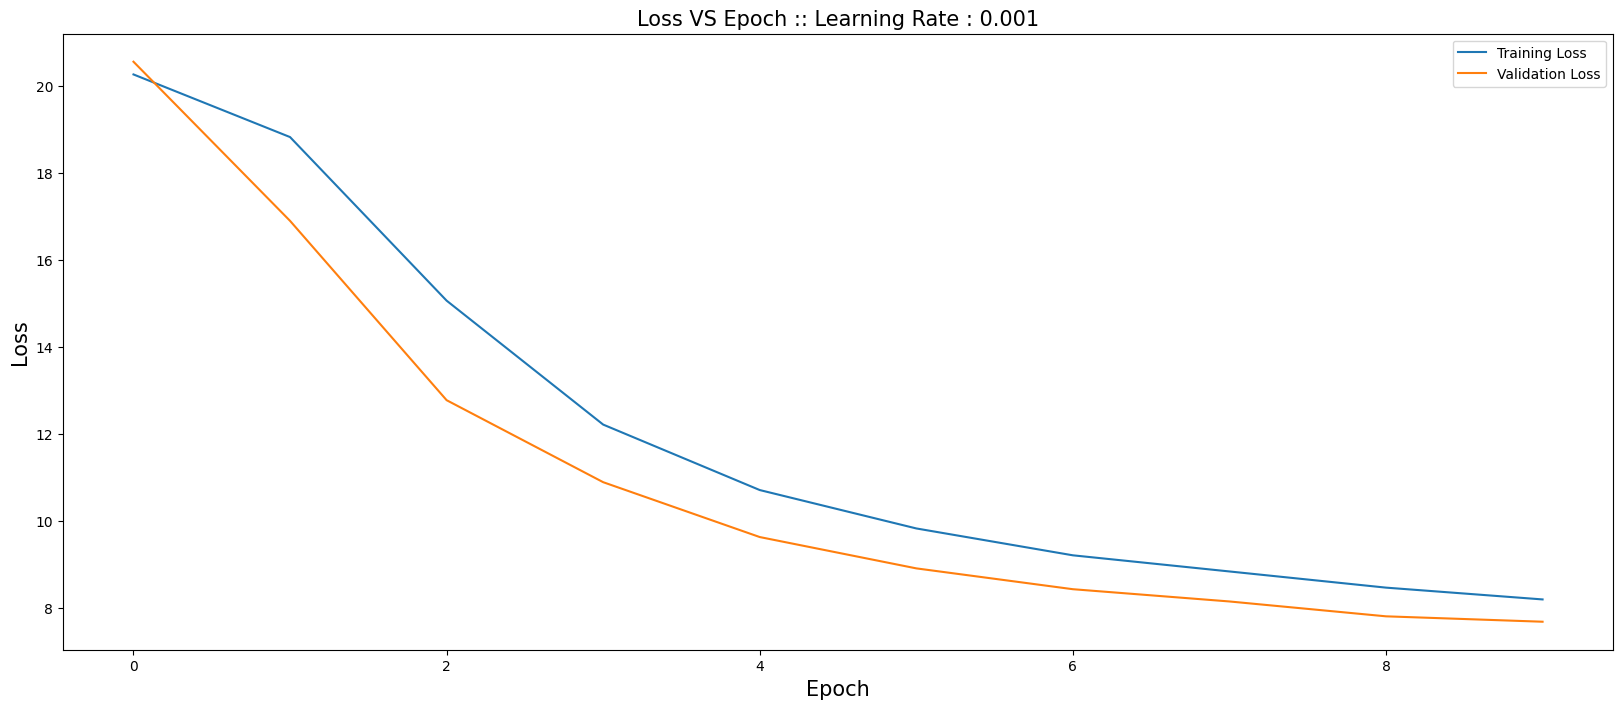

In [28]:
model_3.plot()

Model 1 gives more steeper graph than so this will give better accuracy than other, First it got increase and then decrease